In [1]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from numpy import *
from numpy import linalg as la
import pandas as pd
from sklearn.datasets import load_iris

In [2]:
d=load_iris()
features = d.data
feature_names = d.feature_names
target = d.target
target_names = d.target_names
data=features

pd.DataFrame(features, columns=feature_names)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


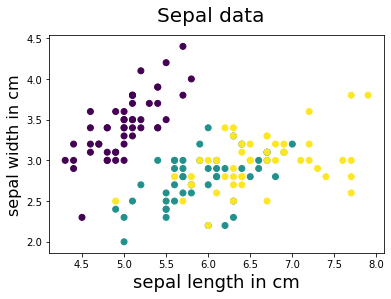

In [3]:
fig = plt.figure()

# set title and labels
fig.suptitle('Sepal data', fontsize=20)
plt.xlabel('sepal length in cm', fontsize=18)
plt.ylabel('sepal width in cm', fontsize=16)

# plot all samples
plt.scatter(features[:, 0], features[:, 1], c=target)
plt.show()

In [4]:
class_set = ['setosa','versicolor','virginica']
avg_set = []

# save sample data as matrix
X = empty((0))

# save number of cols and rows
sample_count = 0
feature_count = 0

# parameters of GMM
k = len(class_set)
init_cov = []
init_mu = []
init_phi = []

# output result
result = pd.DataFrame(columns=['sepal length', 'sepal width', 'petal length', 'petal width','class', 'Prob'])
centroids = []

In [5]:
# load data as numpy array
def load_data(data_set):
    X = mat(data_set.T[:].T)
    sample_count, feature_count = shape(X)
    avg_set = [average(col) for col in data_set.T[:]]

    return X, sample_count, feature_count, avg_set

# init parameters
def init_par(k, X, init_phi, init_mu, init_cov, feature_count):
    # init phi distribution
    for i in range(k):
        init_phi.append(1 / k)

    # randomly select k sample as initial mu of k class
    init_mu = [X[i, :] for i in random.randint(0,150,size=k)]

    # init identity matrix as initial covariance matrix
    init_cov = [mat(np.identity(feature_count)) for _ in range(k)]
    
    return init_phi, init_mu, init_cov

In [6]:
X, sample_count, feature_count, avg_set = load_data(features)
init_phi, init_mu, init_cov = init_par(k, X, init_phi, init_mu, init_cov, feature_count)

In [7]:
# calculate multivariate Normal distribution probabilities of each sample(gamma)
def G_prob(x, mu, cov):
    n = len(x[0])
    e_power = float(-0.5 * (x - mu) * (cov.I) * ((x - mu).T))
    Deno = power(2 * pi, n / 2) * power(linalg.det(cov), 0.5)
    gamma = power(e, e_power) / Deno
    return gamma

# implement EM Algorithm
def EM(X, init_phi, init_cov, init_mu, k, sample_count, feature_count):

    # init parameters
    phi = init_phi
    cov = init_cov
    mu = init_mu

    # init probabilities set
    gamma = mat(zeros((sample_count, k)))

    # Start Iteration
    dif = 1
    threshold = 1e-3
    while dif > threshold:
        mu_pre = [item for item in mu]
        # step E
        for j in range(sample_count):
            px = 0
            for i in range(k):
                gamma[j, i] = phi[i] * G_prob(X[j, :], mu[i], cov[i])
                px += gamma[j, i]
            for i in range(k):
                gamma[j, i] /= px
        sum_gamma = sum(gamma, axis=0)

        # step M
        for i in range(k):
            mu[i] = mat(zeros((1, feature_count)))
            cov[i] = mat(zeros((feature_count, feature_count)))
            for j in range(sample_count):
                mu[i] += gamma[j, i] * X[j, :]
            mu[i] /= sum_gamma[0, i]
            for j in range(sample_count):
                cov[i] += gamma[j, i] * (X[j, :] - mu[i]).T * (X[j, :] - mu[i])
            cov[i] /= sum_gamma[0, i]
            phi[i] = sum_gamma[0, i] / sample_count

        # check whether mu are convergence
        dif = 0
        for i in range(k):
            distance = (mu[i]-mu_pre[i])*(mu[i]-mu_pre[i]).T
            dif += distance[0,0]
    return gamma

# cluster samples to k groups
def cluster(X, init_phi, init_cov, init_mu, k, sample_count, feature_count, result, centroids):
    # init centroids set for different classes
    gamma = EM(X, init_phi, init_cov, init_mu, k, sample_count, feature_count)
    classification = mat(zeros((sample_count, 2)))


    for i in range(sample_count):
        # Align to groups (return the index of biggest probability, and such prob)
        classification[i, :] = argmax(gamma[i, :]), amax(gamma[i, :])
        temp = [item for item in squeeze(np.asarray(X[i, :]))] + [argmax(gamma[i, :]), amax(gamma[i, :])]
        result.loc[i] = temp

        # update centroids
    for j in range(k):
        pointsInCluster = X[nonzero(classification[:, 0].A == j)[0]]
        centroids.append(mean(pointsInCluster, axis=0))

    # set 'class' column data type to int
    result['class'] = pd.to_numeric(result['class'], downcast='signed', errors='coerce')
    
    return result, centroids

In [8]:
result, centroids = cluster(X, init_phi, init_cov, init_mu, k, sample_count, feature_count, result, centroids)

In [9]:
print(result)

     sepal length  sepal width  petal length  petal width  class      Prob
0             5.1          3.5           1.4          0.2      2  1.000000
1             4.9          3.0           1.4          0.2      2  1.000000
2             4.7          3.2           1.3          0.2      2  1.000000
3             4.6          3.1           1.5          0.2      2  1.000000
4             5.0          3.6           1.4          0.2      2  1.000000
..            ...          ...           ...          ...    ...       ...
145           6.7          3.0           5.2          2.3      1  1.000000
146           6.3          2.5           5.0          1.9      1  0.999351
147           6.5          3.0           5.2          2.0      1  0.995867
148           6.2          3.4           5.4          2.3      1  0.999988
149           5.9          3.0           5.1          1.8      1  0.892074

[150 rows x 6 columns]


In [10]:
print(result['class'].values.tolist())
print('-----')
print(target)

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
-----
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


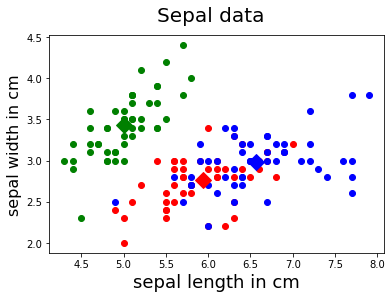

In [11]:
# set dot type and color
mark_sample = ['ro', 'bo', 'go', 'ok']
mark_centroids = ['Dr', 'Db', 'Dg', 'Dk']
if k > len(mark_sample):
    print("k is too large")

fig = plt.figure()
# plot all samples
for i in range(sample_count):
    markIndex = result['class'].iloc[i]
    plt.plot(result['sepal length'].iloc[i], result['sepal width'].iloc[i], mark_sample[markIndex])

# plot centroids
for i in range(k):
    plt.plot(centroids[i][0, 0], centroids[i][0, 1], mark_centroids[i], markersize=12)

# set title and labels
fig.suptitle('Sepal data', fontsize=20)
plt.xlabel('sepal length in cm', fontsize=18)
plt.ylabel('sepal width in cm', fontsize=16)

plt.show()

In [8]:
filepath = '/opt/share/takkan/samples/aiueo_trimmed.wav'
n_mfcc = 20
sr = 16000
signal, _ = librosa.load(filepath, sr=sr)
mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=n_mfcc)

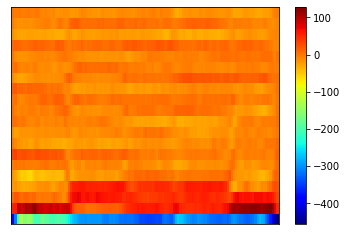

In [9]:
fig = plt.figure()
librosa.display.specshow(mfcc, cmap='jet')
plt.colorbar()
plt.show()

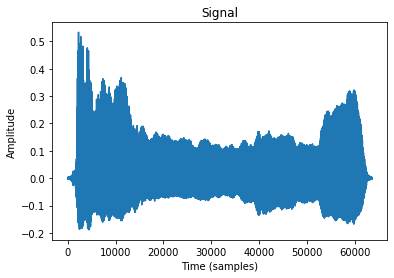

In [10]:
fig = plt.figure()
plt.plot(signal)
plt.title('Signal')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
fig.show()

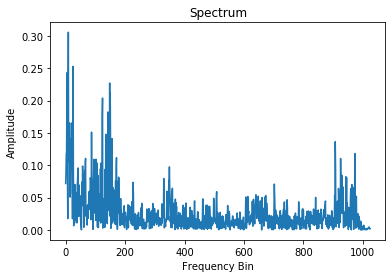

In [11]:
n_fft = 2048
signal_ft = np.abs(librosa.stft(signal[:n_fft], hop_length = n_fft+1))

fig = plt.figure()
plt.plot(signal_ft)
plt.title('Spectrum')
plt.xlabel('Frequency Bin')
plt.ylabel('Amplitude')
fig.show()